# 论文复现：Read Like Humans: Autonomous, Bidirectional and Iterative Language Modeling for Scene Text Recognition
本项目基于作者的开源代码https://github.com/FangShancheng/ABINet.git ，利用paddle框架复现了ABINet算法。所有代码上传至https://github.com/Huntersdeng/abinet-paddle.git 。

## ABINet
ABINet整体框架包括视觉模型Vision Model、Language Model以及特征融合模型Fusion Model。ABINet算法的整体框架为：
1. 视觉模型首先提取图片中的视觉特征$F_v$，并使用softmax分类器获得视觉预测文本$y_v$；
2. 将$y_v$输入到语言模型中，利用文本间的语义信息，提取出语义特征$F_l$与语义预测文本$y_l$；
3. 融合模型将视觉特征$F_v$与语义特征$F_l$融合为融合特征$F_f$，并输入到分类器中得到第一轮融合文本序列$y_{l}^1$；
4. 融合文本序列$y_{l}^1$再次输入到语言模型中，重复2-4步n次。
    
<table>
<td> 
<img src="figs/doc/framework.bmp" style="height:200;">
</td> 
<td> 
<img src="figs/doc/overview.bmp" style="height:200;">
</td> 
</table>
<caption><center> **Figure 1**: A schematic overview of ABINet.</center></caption>

In [32]:
import paddle
from paddle import nn, Tensor
from paddle.nn import (Dropout, LayerNorm, Linear, 
                       Layer, LayerList, Sequential, 
                       Upsample, Conv2D, ReLU, BatchNorm2D)
from paddle.nn import functional as F

## 加载模型配置
import yaml
with open('./configs/abinet.yml', 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
cfg

{'Global': {'max_length': 25, 'character_dict_path': 'charset_36.txt'},
 'Architecture': {'d_model': 512,
  'nhead': 8,
  'd_inner': 2048,
  'dropout': 0.1,
  'activation': 'relu',
  'iter_size': 3,
  'Vision': {'num_layers': 3},
  'Language': {'num_layers': 4, 'detach': True}}}

## 文本序列建模
- 文本字符类别分为37类，包括26个英文字母、10个阿拉伯数字、以及一个结尾示意符$\text{<eos>}$
- 建立映射，其中‘<eos>’对应0，‘a’对应1，依次类推，具体参考charset_36.txt
- 设定文本的最大长度$N$，若输入文本长度不足，则使用结尾示意符补齐为长度为$N+1$的序列
    - 例如，若设定的最大长度为10，输入文本为football，则补齐为长度为11的序列[f,o,o,t,b,a,l,l,$\text{<eos>}$,$\text{<eos>}$,$\text{<eos>}$]

## 模型整体建模
- 长度函数：根据模型输出计算文本长度
- 解码函数：将模型输出解码为文本

In [4]:
## ./modules/model.py
from modules.utils import CharsetMapper


class Model(nn.Layer):

    def __init__(self, config):
        super().__init__()
        self.max_length = config['max_length'] + 1
        self.charset = CharsetMapper(config['character_dict_path'], max_length=self.max_length)

    def _get_length(self, logit, axis=-1):
        """ Greed decoder to obtain length from logit"""
        out = (logit.argmax(axis=-1) == self.charset.null_label)
        abn = out.any(axis)
        out = ((out.astype(paddle.int32).cumsum(axis) == 1) & out).astype(paddle.int32)
        out = out.argmax(axis, dtype='int32')
        out = out + 1  # additional end token
        out = paddle.where(abn, out, paddle.to_tensor(logit.shape[1], dtype=paddle.int32).broadcast_to(out.shape))
        return out

    def _get_text(self, logit):
        """ Greed decode """
        out = F.softmax(logit, axis=2)
        pt_text, pt_scores, pt_lengths = [], [], []
        for o in out:
            text = self.charset.get_text(o.argmax(axis=1), padding=False, trim=False)
            text = text.split(self.charset.null_char)[0]  # end at end-token
            pt_text.append(text)
            pt_scores.append(o.max(axis=1))
            pt_lengths.append(min(len(text) + 1, self.charset.max_length))  # one for end-token
        return pt_text, pt_scores, pt_lengths

## 视觉模型
### 主要结构
- 主干网络：ResNet45 + Transformer encoder
- 预测头：Position Attention
- 分类器

### 算法流程
1. 主干网络提取输入图片的视觉特征，获得Feature map$F$
2. Position Attention模块仅使用文本的位置编码作为注意力机制的query，是一种并行的attention方法。注意力机制中的key和value由$F$映射得到，其中key对应的为一个mini U-net，而value对应的为等值映射

<img src="figs/doc/vm.jpg" align=center>

### 主干网络
#### ResNet45
文本识别中常用的一种ResNet，由ResNet50修改而来。ResNet45中共包含5个Residual块，并仅在第一和第三个Residual块之后执行下采样操作
#### Transformer encoder
提出于论文《Attention is all you need》。其由多层layer级联而成，每个layer都包含Multi-Head Self-Attention、Feed Forward Network、Layer Normalization以及残差连接，具体见下图。相比于RNN，由于Multi-Head Self-Attention能够计算全局的关联， Transformer encoder在识别不规则文本时能够提取更加准确的序列信息。

<img src="figs/doc/trans_encoder.bmp"  width = "300" align=center>


In [14]:
import math
from modules.utils import get_activation_fn, get_clones

class TransformerEncoder(Layer):
    r"""TransformerEncoder is a stack of N encoder layers

    Args:
        encoder_layer: an instance of the TransformerEncoderLayer() class (required).
        num_layers: the number of sub-encoder-layers in the encoder (required).
        norm: the layer normalization component (optional).

    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        >>> src = paddle.rand(10, 32, 512)
        >>> out = transformer_encoder(src)
    """
    __constants__ = ['norm']

    def __init__(self, encoder_layer, num_layers, norm=None):
        super(TransformerEncoder, self).__init__()
        self.layers = get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src, mask=None):
        r"""Pass the input through the encoder layers in turn.

        Args:
            src: the sequence to the encoder (required).
            mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        output = src

        for i, mod in enumerate(self.layers):
            output = mod(output, src_mask=mask)

        if self.norm is not None:
            output = self.norm(output)

        return output

class TransformerEncoderLayer(Layer):
    r"""TransformerEncoderLayer is made up of self-attn and feedforward network.
    This standard encoder layer is based on the paper "Attention Is All You Need".
    Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
    Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in
    Neural Information Processing Systems, pages 6000-6010. Users may modify or implement
    in a different way during application.

    Args:
        d_model: the number of expected features in the input (required).
        nhead: the number of heads in the multiheadattention models (required).
        d_inner: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of intermediate layer, relu or gelu (default=relu).

    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> src = paddle.rand(10, 32, 512)
        >>> out = encoder_layer(src)
    """

    def __init__(self, d_model, nhead, d_inner=2048, dropout=0.1, 
                 activation="relu", **kwargs):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, d_inner)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(d_inner, d_model)

        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

        self.activation = get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerEncoderLayer, self).__setstate__(state)

    def forward(self, src, src_mask=None):
        r"""Pass the input through the encoder layer.

        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        src2, attn = self.self_attn(src, src, src, mask=src_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        
        return src
    
class MultiHeadAttention(Layer):
    def __init__(self, d_model, h, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = get_clones(Linear(d_model, d_model), 4)
        self.dropout = Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        tgt_len, nbatches, embed_size = query.shape

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [l(x).reshape((tgt_len, nbatches*self.h, self.d_k)).transpose((1,0,2))
             for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attention_map = self.attention(query, key, value, mask=mask,
                                     dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose((1,0,2)) \
            .reshape((tgt_len, nbatches, embed_size))

        return self.linears[-1](x), attention_map.sum(axis=1) / self.h


    def attention(self, query, key, value, mask=None, dropout=None):
        "Compute 'Scaled Dot Product Attention'"

        nbatches = query.shape[0]//self.h
        tgt_len = query.shape[1]
        d_k = query.shape[2]

        scores = paddle.matmul(query, key.transpose((0,2,1))) \
                / math.sqrt(d_k)
        scores = scores.reshape((nbatches, self.h, tgt_len, -1))
        if mask is not None:
            # print(mask)
            scores = scores + mask
        else:
            pass

        p_attn = F.softmax(scores, axis=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return paddle.matmul(p_attn.reshape((nbatches*self.h, tgt_len, -1)), value), p_attn

class PositionalEncoding(Layer):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = Dropout(p=dropout)

        pe = paddle.zeros((max_len, d_model))
        position = paddle.arange(0, max_len, dtype=paddle.float32).unsqueeze(1)
        div_term = paddle.exp(paddle.arange(0, d_model, 2).astype(paddle.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = paddle.sin(position * div_term)
        pe[:, 1::2] = paddle.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose([1,0,2])
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.shape[0], :]
        return self.dropout(x)

In [12]:
from modules.resnet import resnet45
class ResTranformer(nn.Layer):
    def __init__(self, config):
        super().__init__()
        self.resnet = resnet45()
        self.pos_encoder = PositionalEncoding(config['d_model'], max_len=8*32)
        encoder_layer = TransformerEncoderLayer(**config)
        self.transformer = TransformerEncoder(encoder_layer, config['num_layers'])

    def forward(self, images):
        feature = self.resnet(images)
        n, c, h, w = feature.shape
        feature = feature.reshape((n, c, -1)).transpose((2, 0, 1))
        feature = self.pos_encoder(feature)
        feature = self.transformer(feature)
        feature = feature.transpose((1, 2, 0)).reshape((n, c, h, w))
        return feature

In [17]:
## 构建backbone
cfg_vision = cfg['Architecture']
cfg_vision['max_length'] = cfg['Global']['max_length']
cfg_vision['num_layers'] = cfg_vision['Vision']['num_layers']
backbone = ResTranformer(cfg_vision)
backbone.eval()

#输入一张尺寸为（3,32,128）的图片，观察输出
image = paddle.randn((1,3,32,128))
out = backbone(image)
print("The output shape of backbone is: ", out.shape)

The output shape of backbone is:  [1, 512, 8, 32]


### Position Attention
一种平行注意力机制的方法，用于获得对应位置文本字符的特征向量。
Position Attention中采用的注意力机制为：
$$
attention(Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{e}})V
$$
其中e为backbone输出张量的通道数，Q为文本的位置编码，$K=\mathcal{U}(F)$，$V=\mathcal{I}(F)$，$\mathcal{U}(\cdot)$为一个微型的U-net，$\mathcal{I}(\cdot)$为等值映射。

Position Attention采用了Transformer中使用的位置编码方法，即使用不同频率的正余弦函数来表示位置：
$$
Q(i,2j)=\text{sin}(i/10000^{2j/e})\\
Q(i,2j+1)=\text{sin}(i/10000^{2j/e})
$$

<img src="https://d33wubrfki0l68.cloudfront.net/ef81ee3018af6ab6f23769031f8961afcdd67c68/3358f/img/transformer_architecture_positional_encoding/positional_encoding.png"  width = "800" align=center>
<center>
    位置编码可视化
    
    图片来源：https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
</center>


In [18]:
def encoder_layer(in_c, out_c, k=3, s=2, p=1):
    return nn.Sequential(nn.Conv2D(in_c, out_c, k, s, p),
                         nn.BatchNorm2D(out_c),
                         nn.ReLU(True))

def decoder_layer(in_c, out_c, k=3, s=1, p=1, mode='nearest', scale_factor=None, size=None):
    align_corners = False if mode=='nearest' else True
    return nn.Sequential(nn.Upsample(size=size, scale_factor=scale_factor, 
                                     mode=mode, align_corners=align_corners),
                         nn.Conv2D(in_c, out_c, k, s, p),
                         nn.BatchNorm2D(out_c),
                         nn.ReLU(True))


class PositionAttention(nn.Layer):
    def __init__(self, max_length, in_channels=512, num_channels=64, 
                 h=8, w=32, mode='nearest', **kwargs):
        super().__init__()
        self.max_length = max_length + 1
        self.k_encoder = nn.Sequential(
            encoder_layer(in_channels, num_channels, s=(1, 2)),
            encoder_layer(num_channels, num_channels, s=(2, 2)),
            encoder_layer(num_channels, num_channels, s=(2, 2)),
            encoder_layer(num_channels, num_channels, s=(2, 2))
        )
        self.k_decoder = nn.Sequential(
            decoder_layer(num_channels, num_channels, scale_factor=2, mode=mode),
            decoder_layer(num_channels, num_channels, scale_factor=2, mode=mode),
            decoder_layer(num_channels, num_channels, scale_factor=2, mode=mode),
            decoder_layer(num_channels, in_channels, size=(h, w), mode=mode)
        )

        self.pos_encoder = PositionalEncoding(in_channels, dropout=0, max_len=self.max_length)
        self.project = nn.Linear(in_channels, in_channels)

    def forward(self, x):
        N, E, H, W = x.shape
        k, v = x, x  # (N, E, H, W)

        # calculate key vector
        features = []
        for i in range(0, len(self.k_encoder)):
            k = self.k_encoder[i](k)
            features.append(k)
        for i in range(0, len(self.k_decoder) - 1):
            k = self.k_decoder[i](k)
            k = k + features[len(self.k_decoder) - 2 - i]
        k = self.k_decoder[-1](k)

        # calculate query vector
        # TODO q=f(q,k)
        zeros = paddle.zeros((self.max_length, N, E))  # (T, N, E)
        q = self.pos_encoder(zeros)  # (T, N, E)
        q = q.transpose((1, 0, 2))  # (N, T, E)
        q = self.project(q)  # (N, T, E)
        
        # calculate attention
        attn_scores = paddle.bmm(q, k.flatten(2, 3))  # (N, T, (H*W))
        attn_scores = attn_scores / (E ** 0.5)
        attn_scores = F.softmax(attn_scores, axis=-1)

        v = v.transpose((0, 2, 3, 1)).reshape((N, -1, E))  # (N, (H*W), E)
        attn_vecs = paddle.bmm(attn_scores, v)  # (N, T, E)

        return attn_vecs, attn_scores.reshape((N, -1, H, W))

In [20]:
PA = PositionAttention(**cfg_vision)

## 给定backbone的输出out （1，512，8，32）
v_feature, attn_scores = PA(out)
print('The output shape of position attention: ', v_feature.shape)

The output shape of position attention:  [1, 26, 512]


<img src="figs/doc/vm.jpg" align=center>

In [24]:
## 根据以上模块，构建视觉模型
class BaseVision(Model):
    def __init__(self, config):
        super().__init__(config['Global'])
        cfg_vision = config['Architecture']
        cfg_vision['max_length'] = config['Global']['max_length']
        cfg_vision['num_layers'] = cfg_vision['Vision']['num_layers']
        self.backbone = ResTranformer(cfg_vision)
        self.head = PositionAttention(**cfg_vision)
        self.cls = Linear(cfg_vision['d_model'], self.charset.num_classes)

    def forward(self, images):
        features = self.backbone(images)
        attn_vecs, attn_scores = self.head(features)
        logits = self.cls(attn_vecs) # (N, T, C)
        pt_lengths = self._get_length(logits)

        return {'feature': attn_vecs, 'logits': logits, 'pt_lengths': pt_lengths,
                'attn_scores': attn_scores}
VM = BaseVision(cfg)

In [49]:
## 给定4张图片，观察其输出尺寸
imgs = paddle.randn((4,3,32,128))
VM.eval()
v_res = VM(imgs)
for k,v in v_res.items():
    print('The shape of '+ k +' : ', v.shape)

The shape of feature :  [4, 26, 512]
The shape of logits :  [4, 26, 37]
The shape of pt_lengths :  [4]
The shape of attn_scores :  [4, 26, 8, 32]


<img src="figs/doc/lm.jpg" align=center>

## 语言模型：Blank Cloze Network (BCN)
### 主要结构：多层BCN layer级联构成的BCN
- BCN layer: 一种Transformer decoder layer的变体
    1. 移除了所有self attention模块防止文本前后信息泄漏
    2. 使用了Blank Cloze Mask实现Blank Cloze式的语言模型
- 分类器: linear & softmax 层

### Masked Attention
$$
\text{Masked_attention}(Q,K,V,M) = \text{softmax}(\frac{QK^T}{\sqrt{e}}+M)V
$$
### BCN mask
根据Blank Cloze的思想，算法将遮住某一位置的字符，并根据字符序列的其他字符来预测该位置的字符类别。为了达成这一目的，ABINet中设计了Blank Cloze mask:
$$
    M_{ij} = \left\{\begin{aligned}0,& \quad i\neq j\\
                    -\infty,& \quad i=j
                    \end{aligned}
    \right.
$$
在实现中，我们不仅将mask矩阵对角线位置的字符设为mask，同时也将超过该字符长度的区域设为mask

In [45]:
def get_mask(lengths, max_length):
        masks = []
        for length in lengths:
            N = int(length)
            location_mask = -paddle.eye(max_length) > -1
            padding_mask = paddle.zeros((max_length,max_length))
            padding_mask[:N,:N] = 1
            padding_mask = padding_mask > 0
            mask = location_mask & padding_mask
            mask = (paddle.cast(mask, paddle.float32) - 1.0) * 1e9
            masks.append(mask)
        masks = paddle.stack(masks)
        return masks

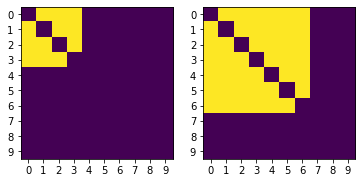

In [46]:
import numpy as np
import matplotlib.pyplot as plt
masks = get_mask([4,7], 10).numpy()
plt.plot()
for i, mask in enumerate(masks):
    plt.subplot(1,2,i+1)
    im_mask = np.zeros_like(mask, dtype=np.uint8)
    im_mask[mask==0] = 255
    im_mask[mask<0] = 0
    plt.imshow(im_mask)
    plt.xticks(range(10))
    plt.yticks(range(10))
plt.show()

上图中紫色为被mask的位置（即prevent from attending），黄色为允许的位置（即allow to attend）

In [28]:
class BCNLayer(Layer):

    def __init__(self, d_model, nhead, d_inner=2048, dropout=0.1, 
                 activation="relu", **kwargs):
        super(BCNLayer, self).__init__()

        self.multihead_attn = MultiHeadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model“
        self.linear1 = Linear(d_model, d_inner)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(d_inner, d_model)

        self.norm2 = LayerNorm(d_model)
        self.norm3 = LayerNorm(d_model)
        self.dropout2 = Dropout(dropout)
        self.dropout3 = Dropout(dropout)

        self.activation = get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(BCNLayer, self).__setstate__(state)

    def forward(self, tgt, memory, memory_mask=None):

        tgt2, attn2 = self.multihead_attn(tgt, memory, memory, mask=memory_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        
        return tgt
    
class BCNModel(Layer):

    __constants__ = ['norm']

    def __init__(self, decoder_layer, num_layers, norm=None):
        super(BCNModel, self).__init__()
        self.layers = get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, tgt, memory, memory_mask=None):

        output = tgt

        for mod in self.layers:
            output = mod(output, memory, memory_mask=memory_mask)

        if self.norm is not None:
            output = self.norm(output)

        return output

In [31]:
class BCNLanguage(Model):
    def __init__(self, config):
        super().__init__(config['Global'])

        cfg_language = config['Architecture']
        cfg_language['max_length'] = config['Global']['max_length']
        

        self.max_length = self.charset.max_length
        self.d_model = cfg_language['d_model']
        self.num_layers = cfg_language['Language']['num_layers']
        self.detach = cfg_language['Language']['detach']

        self.project = nn.Linear(self.charset.num_classes, self.d_model, bias_attr=False)
        self.token_encoder = PositionalEncoding(self.d_model, max_len=self.max_length)
        self.pos_encoder = PositionalEncoding(self.d_model, dropout=0, max_len=self.max_length)
        decoder_layer = BCNLayer(**cfg_language)
        self.model = BCNModel(decoder_layer, self.num_layers)

        self.cls = nn.Linear(self.d_model, self.charset.num_classes)

    def forward(self, tokens, lengths):
        """
        Args:
            tokens: (N, T, C) where T is length, N is batch size and C is classes number
            lengths: (N,)
        """
        if self.detach: tokens = tokens.detach()
        embed = self.project(tokens)  # (N, T, E)
        embed = embed.transpose((1, 0, 2))  # (T, N, E)
        embed = self.token_encoder(embed)  # (T, N, E)
        mask = self._get_mask(lengths, self.max_length)

        zeros = paddle.zeros_like(embed)
        qeury = self.pos_encoder(zeros)
        output = self.model(qeury, embed, memory_mask=mask)  # (T, N, E)
        output = output.transpose((1, 0, 2))  # (N, T, E)

        logits = self.cls(output)  # (N, T, C)
        pt_lengths = self._get_length(logits)

        res =  {'feature': output, 'logits': logits, 'pt_lengths': pt_lengths}
        return res

    @staticmethod
    def _get_mask(lengths, max_length):
        masks = []
        for length in lengths:
            N = int(length)
            location_mask = -paddle.eye(max_length) > -1
            padding_mask = paddle.zeros((max_length,max_length))
            padding_mask[:N,:N] = 1
            padding_mask = padding_mask > 0
            mask = location_mask & padding_mask
            mask = (paddle.cast(mask, paddle.float32) - 1.0) * 1e9
            masks.append(mask)
        masks = paddle.stack(masks)
        return masks
    
LM = BCNLanguage(cfg)

In [44]:
## 给定4个文本序列，观察其输出
texts = paddle.randn((4,26,37)) ## 26为最大文本长度25+1, 37为字符类别36+1
lengths = paddle.to_tensor([4,6,3,9]) ## 4，6，3，9为任意设置的长度
l_res = LM(texts, lengths)
for k,v in l_res.items():
    print('The shape of output '+k+' : ', v.shape)

The shape of output feature :  [4, 26, 512]
The shape of output logits :  [4, 26, 37]
The shape of output pt_lengths :  [4]


## 融合模型
### Gate mechanism:
$$
G = \sigma([F_v,F_l]W_f),\\
F_f = G\odot F_v+(1-G)\odot F_l
$$
其中$\odot$为矩阵的逐元素相乘

In [47]:
class BaseAlignment(Model):
    def __init__(self, config):
        super().__init__(config['Global'])
        d_model = config['Architecture']['d_model']
        self.max_length = self.charset.max_length  # additional stop token
        self.linear = nn.Linear(2 * d_model, d_model)
        self.cls = nn.Linear(d_model, self.charset.num_classes)

    def forward(self, l_feature, v_feature):
        """
        Args:
            l_feature: (N, T, E) where T is length, N is batch size and d is dim of model
            v_feature: (N, T, E) shape the same as l_feature 
            l_lengths: (N,)
            v_lengths: (N,)
        """
        f = paddle.concat((l_feature, v_feature), axis=2)
        f_att = F.sigmoid(self.linear(f))
        output = f_att * v_feature + (1 - f_att) * l_feature

        logits = self.cls(output)  # (N, T, C)
        pt_lengths = self._get_length(logits)

        return {'logits': logits, 'pt_lengths': pt_lengths}

Align = BaseAlignment(cfg)
Align.eval()

In [50]:
## 给定视觉特征和语言特征，观察其输出
l_feature = l_res['feature']
v_feature = v_res['feature']
print('The shape of l_feature: ', l_feature.shape)
print('The shape of v_feature: ', v_feature.shape)
a_res = Align(l_feature, v_feature)
for k,v in a_res.items():
    print('The shape of output '+k+' : ', v.shape)

The shape of l_feature:  [4, 26, 512]
The shape of v_feature:  [4, 26, 512]
The shape of output logits :  [4, 26, 37]
The shape of output pt_lengths :  [4]


## ABINet
基于以上视觉模型、语言模型、融合模型的结构，通过迭代方法，最终形成ABINet

In [51]:
class ABINetIterModel(Model):
    def __init__(self, config):
        super().__init__(config['Global'])
        self.iter_size = config['Architecture']['iter_size']
        self.max_length = self.charset.max_length
        self.vision = BaseVision(config)
        self.language = BCNLanguage(config)
        self.alignment = BaseAlignment(config)

    def forward(self, images, *args):
        v_res = self.vision(images)
        a_res = v_res
        all_l_res, all_a_res = [], []
        for _ in range(self.iter_size):
            tokens = F.softmax(a_res['logits'], axis=-1)
            lengths = a_res['pt_lengths'].clip(2, self.max_length)
            l_res = self.language(tokens, lengths)
            all_l_res.append(l_res)
            a_res = self.alignment(l_res['feature'], v_res['feature'])
            all_a_res.append(a_res)
        if self.training:
            return all_a_res, all_l_res, v_res
        else:
            return a_res, all_l_res[-1], v_res

ABINet = ABINetIterModel(cfg)
ABINet.eval()

In [52]:
## 载入作者提供的权重
state = paddle.load('pretrain_models/pretrain_vm.pdparams')
ABINet.vision.load_dict(state)
state = paddle.load('pretrain_models/pretrain_lm.pdparams')
ABINet.language.load_dict(state)
state = paddle.load('pretrain_models/pretrain_alignment.pdparams')
ABINet.alignment.load_dict(state)

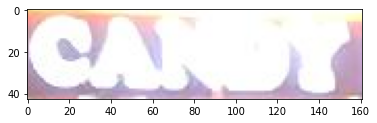

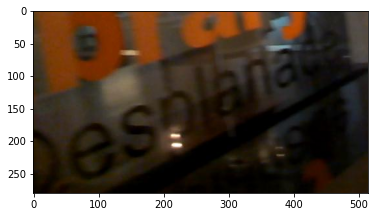

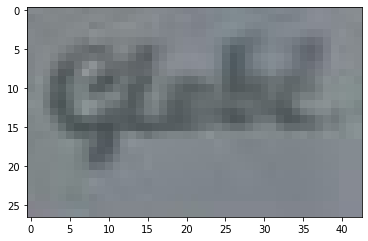

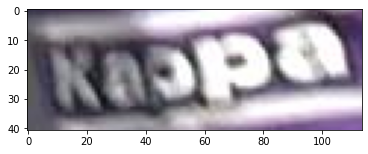

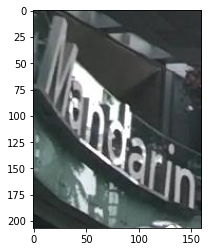

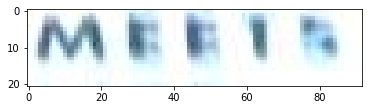

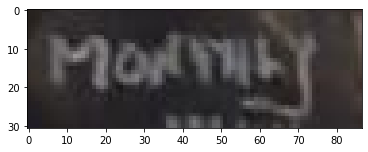

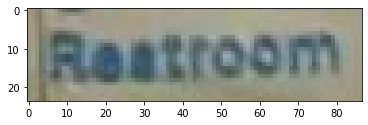

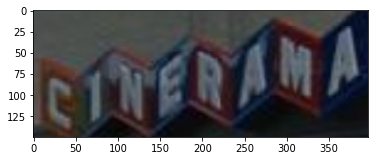

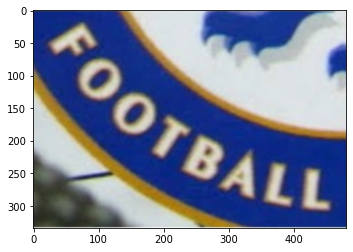

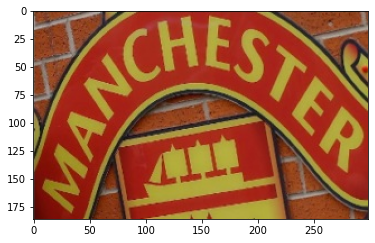

In [57]:
## 测试示例图片
import os
from PIL import Image
paths = [os.path.join('./figs/test', fname) for fname in os.listdir('./figs/test')]
paths = sorted(paths)
num = len(paths)
for i, im_path in enumerate(paths):
    img = Image.open(im_path).convert('RGB')
    plt.imshow(img)
    plt.show()

In [61]:
from modules.utils import preprocess
for im_path in paths:
    img = Image.open(im_path).convert('RGB')
    img = paddle.to_tensor(preprocess(img, 128 ,32)).unsqueeze(0)
    out, _, _ = ABINet(img)
    pt_text, pt_scores, pt_lengths = ABINet._get_text(out['logits'])
    print(f'{im_path}: {pt_text[0]}')

./figs/test\CANDY.png: candy
./figs/test\ESPLANADE.png: esplanade
./figs/test\GLOBE.png: globe
./figs/test\KAPPA.png: kappa
./figs/test\MANDARIN.png: mandarin
./figs/test\MEETS.png: meets
./figs/test\MONTHLY.png: monthly
./figs/test\RESTROOM.png: restroom
./figs/test\cinerama.jpg: cinerama
./figs/test\football.jpg: football
./figs/test\manchester.jpg: manchester
